# Cross-Assay Integrative Analyses

In [16]:
import polars as pl
import os
import seaborn as sns
import glob
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Loading allele information

### 1.1 Pillar Dataset Alleles

In [2]:
pillar_clinvar_df = pl.read_csv("../../1_allele_collection/1_inputs/raw_inputs/pillar_data/pillar_data_clinvar38_051325_wREVEL.csv", 
                                schema_overrides={"Chrom": pl.String, 'aa_pos': pl.String, 'auth_reported_score': pl.String})
print("Original pillar dataset shape:", pillar_clinvar_df.shape)

## filter the SNP variants only
pillar_clinvar_single_aa_df = pillar_clinvar_df.filter(
    (pl.col("consequence").str.contains("sense")) & \
    (pl.col("ref_allele").str.len_chars()==1) & (pl.col("alt_allele").str.len_chars()==1) & \
    (pl.col("hg38_start").is_not_null()) & (pl.col("hg38_end").is_not_null())
).drop_nulls(subset="hgvs_p").with_columns(
    pl.col("hg38_start").cast(pl.Int32).cast(pl.String).alias("nuc_loc")
)

print("Filtered missense/SNP pillar dataset shape:", pillar_clinvar_single_aa_df.shape)

pillar_clinvar_single_aa_df = pillar_clinvar_single_aa_df.with_columns(
    pl.col("hgvs_p").str.split(".").list.get(-1).alias("aa_change")
).with_columns(
    pl.concat_str([pl.col("Gene"),pl.col("aa_change")], separator="_").alias("gene_variant"),
    pl.lit(True).alias("Pillar_Set")
).sort("gene_variant", "gnomad_MAF", descending=[False,False])

print("Number of unique gene variants:", pillar_clinvar_single_aa_df.unique(subset="gene_variant").shape[0])
print("Number of unique genes:", pillar_clinvar_single_aa_df.unique(subset="Gene").shape[0])

# display(pillar_clinvar_single_aa_df) #.filter(pl.col("Ref_seq_transcript_ID").str.contains("NC_"))
pillar_clinvar_single_aa_df.head()

Original pillar dataset shape: (1063392, 59)
Filtered missense/SNP pillar dataset shape: (128386, 60)
Number of unique gene variants: 61155
Number of unique genes: 33


ID,Dataset,Gene,HGNC_id,Chrom,STRAND,hg19_pos,hg38_start,hg38_end,ref_allele,alt_allele,auth_transcript_id,transcript_pos,transcript_ref,transcript_alt,aa_pos,aa_ref,aa_alt,hgvs_c,hgvs_p,consequence,auth_reported_score,auth_reported_rep_score,auth_reported_func_class,splice_measure,gnomad_MAF,clinvar_sig,clinvar_star,clinvar_date_last_reviewed,nucleotide_or_aa,MaveDB URN (score set),Ensembl_transript_ID,Ref_seq_transcript_ID,Model_system,Assay_type,Phenotype_measured,Phenotype_detail,IGVF_produced,simplified_consequence,Flag,REVEL,Interval 1 name,Interval 1 range,Interval 1 MaveDB class,Interval 2 name,Interval 2 range,Interval 2 MaveDB class,Interval 3 name,Interval 3 range,Interval 3 MaveDB class,Interval 4 name,Interval 4 range,Interval 4 MaveDB class,Interval 5 name,Interval 5 range,Interval 5 MaveDB class,Interval 6 name,Interval 6 range,Interval 6 MaveDB class,nuc_loc,aa_change,gene_variant,Pillar_Set
str,str,str,f64,str,f64,str,f64,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,bool
"""ASPA_Grønbæk-Thygesen_2024_tox…","""ASPA_Grønbæk-Thygesen_2024_tox…","""ASPA""",756.0,"""17""",1.0,null,3.483509e6,3.483509e6,"""C""","""A""",null,"""443""",null,null,"""148""","""A""","""D""","""c.443C>A""","""p.Ala148Asp""","""missense_variant""","""-0.1191""",null,null,"""No""",6.1958e-7,null,null,null,"""aa""","""urn:mavedb:00000657-a-2""","""ENST00000263080.3""","""NM_000049.4""","""immortalized human cells""","""Reporter""","""Cell viability""","""protein toxicity""","""No""","""missense_variant""",null,0.714,"""Toxic""","""(0.6, Inf)""","""Abnormal""","""Non-toxic""","""(-Inf, 0.4)""","""Normal""",null,null,null,null,null,null,null,null,null,null,null,null,"""3483509""","""Ala148Asp""","""ASPA_Ala148Asp""",true
"""ASPA_Grønbæk-Thygesen_2024_abu…","""ASPA_Grønbæk-Thygesen_2024_abu…","""ASPA""",756.0,"""17""",1.0,null,3.483509e6,3.483509e6,"""C""","""A""",null,"""443""",null,null,"""148""","""A""","""D""","""c.443C>A""","""p.Ala148Asp""","""missense_variant""","""0.9495""",null,null,"""No""",6.1958e-7,null,null,null,"""aa""","""urn:mavedb:00000657-a-1""","""ENST00000263080.3""","""NM_000049.4""","""immortalized human cells""","""Reporter""","""Fluorescence""","""protein stability""","""No""","""missense_variant""",null,0.714,"""low abundance""","""(-Inf, 0.2)""","""Abnormal""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""3483509""","""Ala148Asp""","""ASPA_Ala148Asp""",true
"""ASPA_Grønbæk-Thygesen_2024_tox…","""ASPA_Grønbæk-Thygesen_2024_tox…","""ASPA""",756.0,"""17""",1.0,null,3.483509e6,3.483509e6,"""C""","""G""",null,"""443""",null,null,"""148""","""A""","""G""","""c.443C>G""","""p.Ala148Gly""","""missense_variant""","""0.1248""",null,null,"""No""",null,null,null,null,"""aa""","""urn:mavedb:00000657-a-2""","""ENST00000263080.3""","""NM_000049.4""","""immortalized human cells""","""Reporter""","""Cell viability""","""protein toxicity""","""No""","""missense_variant""",null,0.679,"""Toxic""","""(0.6, Inf)""","""Abnormal""","""Non-toxic""","""(-Inf, 0.4)""","""Normal""",null,null,null,null,null,null,null,null,null,null,null,null,"""3483509""","""Ala148Gly""","""ASPA_Ala148Gly""",true
"""ASPA_Grønbæk-Thygesen_2024_abu…","""ASPA_Grønbæk-Thygesen_2024_abu…","""ASPA""",756.0,"""17""",1.0,null,3.483509e6,3.483509e6,"""C""","""G""",null,"""443""",null,null,"""148""","""A""","""G""","""c.443C>G""","""p.Ala148Gly""","""missense_variant""","""0.2662""",null,null,"""No""",null,null,null,null,"""aa""","""urn:mavedb:00000657-a-1""","""ENST00000263080.3""","""NM_000049.4""","""immortalized human cells""","""Reporter""","""Fluorescence""","""protein stability""","""No""","""missense_variant""",null,0.679,"""low abundance""","""(-Inf, 0.2)""","""Abnormal""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""3483509""","""Al

### 1.2 Imaging Data

In [3]:
img_metric_df = pl.DataFrame()
for csv_file in glob.glob("../1_inputs/imaging/*"):
    if "altered_" in csv_file:
        csv_df = pl.read_csv(csv_file)
        altered_cols = [col for col in csv_df.columns if col.endswith("_both_batches")]
        change = csv_file.split("/")[-1].split("_")[1]
        csv_df = csv_df.with_columns(
            pl.col("allele_0").str.split("_").list.get(0).alias("Gene"),
            pl.col("allele_0").alias("gene_variant")
        ).select(
            pl.col(["Gene", "gene_variant", "AUROC_Mean"]+altered_cols)
        ).rename({"AUROC_Mean": f"AUROC_Mean_{change}"}) #"Gene", 
    else:
        metric_type = csv_file.split("/")[-1].split("_")[-2]
        csv_df = pl.read_csv(csv_file).with_columns(
            pl.col("Variant").alias("gene_variant")
        ).select(
            pl.col(["Gene", "gene_variant", "U2OS_paired_t_stat", "U2OS_paired_t_pval"]) #
        ).rename({"U2OS_paired_t_stat": f"t_stat_{metric_type}", "U2OS_paired_t_pval": f"t_pval_{metric_type}"})

    if img_metric_df.is_empty():
        img_metric_df = csv_df
    else:
        img_metric_df = img_metric_df.join(
            csv_df,
            on=["Gene","gene_variant"], #
            how="full",
            coalesce=True
        )

img_metric_df = img_metric_df.with_columns(
    pl.lit(True).alias("VarChAMP_Imaged")
)
print("VarChAMP Imaging assay unique variants:", img_metric_df.unique(subset=["gene_variant"]).shape[0])
img_metric_df

VarChAMP Imaging assay unique variants: 475


Gene,gene_variant,AUROC_Mean_Morph,Altered_Morph_95_both_batches,Altered_Morph_99_both_batches,t_stat_cell-count,t_pval_cell-count,t_stat_prot-abundance,t_pval_prot-abundance,AUROC_Mean_GFP,Altered_GFP_95_both_batches,Altered_GFP_99_both_batches,VarChAMP_Imaged
str,str,f64,bool,bool,f64,f64,f64,f64,f64,bool,bool,bool
"""RAF1""","""RAF1_Phe22Leu""",0.65935,false,false,3.724426,0.067943,-1.462482,1.0,0.659481,false,false,true
"""CCM2""","""CCM2_Ile432Thr""",0.807628,false,false,4.3807e7,0.067872,-2.743227,1.0,0.9896,true,true,true
"""BRCA1""","""BRCA1_Ser611Arg""",0.968193,true,true,3.030701,0.022173,-4.562711,0.01245,0.914962,false,false,true
"""CCM2""","""CCM2_Ser84Asn""",0.81458,false,false,3.816347,0.120511,-7.167999,0.000433,0.911153,false,false,true
"""CCM2""","""CCM2_Gly407Asp""",0.829441,false,false,2.3705e7,0.026605,-4.642157,0.007201,0.882196,false,false,true
…,…,…,…,…,…,…,…,…,…,…,…,…
"""F9""","""F9_Ser406Leu""",0.916284,true,false,1.0,0.350617,-4.644572,0.002357,0.891614,false,false,true
"""SHOC2""","""SHOC2_Leu174Phe""",0.933819,true,false,3.41565,0.011201,1.217907,0.262714,0.841495,false,false,true
"""GSS""","""GSS_Arg125Cys""",0.570654,false,false,null,null,null,null,0.656089,false,false,true


In [4]:
pillar_img_df = pillar_clinvar_single_aa_df.join( ## .unique(subset=["gene_variant"])
    img_metric_df,
    left_on="gene_variant",
    right_on="gene_variant",
    how="full",
    coalesce=True,
    suffix="_img"
)
print("VarChAMP Imaged Variants overlapped with Pillar:", pillar_img_df.drop_nulls(subset=["Pillar_Set","VarChAMP_Imaged"]).unique(subset="gene_variant").shape[0])

VarChAMP Imaged Variants overlapped with Pillar: 87


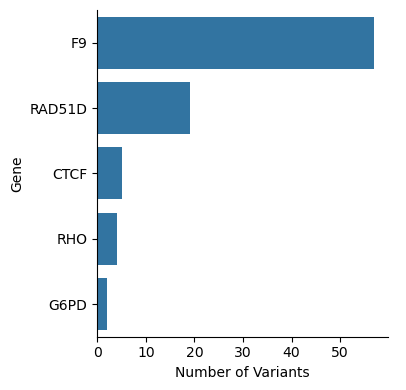

In [8]:
g = sns.catplot(data=pillar_img_df.drop_nulls(subset=["Pillar_Set","VarChAMP_Imaged"]).unique(subset="gene_variant").group_by("Gene").len().sort(by="len", descending=True).rename({"len":"Number of Variants"}).to_pandas(), 
                x="Number of Variants", y="Gene", kind="bar", height=4, aspect=1)

### 1.3 DUAL-IPA and PPI alleles

VarChAMP DUAL-IPA assay unique variants: 816
VarChAMP DUALIPA Variants overlapped with Pillar: 23


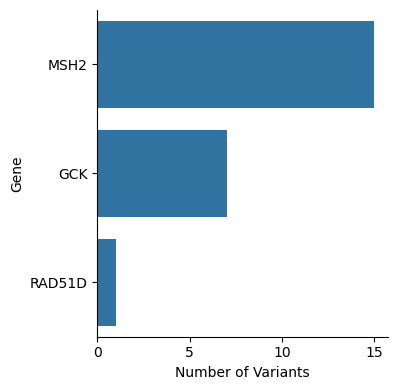

In [12]:
dual_ipa_metric = "zscore_log2"
dual_ipa_thresh = -5

dual_ipa_df = pl.read_csv("../1_inputs/dual_ipa/abun_scores.csv").with_columns(
    pl.col("allele_0").alias("gene_variant"),
    pl.lit(True).alias("VarChAMP_DUALIPA"),
    pl.when(pl.col(dual_ipa_metric)<dual_ipa_thresh)
    .then(pl.lit(True))
    .otherwise(pl.lit(False))
    .alias("DUALIPA_Abundance_Change")
)
print("VarChAMP DUAL-IPA assay unique variants:", dual_ipa_df.unique(subset=["allele_0"]).shape[0])

pillar_img_dual_df = pillar_img_df.join( ## .unique(subset=["gene_variant"])
    dual_ipa_df,
    left_on="gene_variant",
    right_on="gene_variant",
    how="full",
    coalesce=True,
    suffix="_dualipa"
)

print("VarChAMP DUALIPA Variants overlapped with Pillar:", pillar_img_dual_df.drop_nulls(subset=["Pillar_Set","VarChAMP_DUALIPA"]).unique(subset="gene_variant").shape[0])
g = sns.catplot(data=pillar_img_dual_df.drop_nulls(subset=["Pillar_Set","VarChAMP_DUALIPA"]).unique(subset="allele_0").group_by("Gene").len().sort(by="len", descending=True).rename({"len":"Number of Variants"}).to_pandas(), 
                x="Number of Variants", y="Gene", kind="bar", height=4, aspect=1)

VarChAMP PPI assay unique variants: 836
VarChAMP PPI Variants overlapped with Pillar: 35


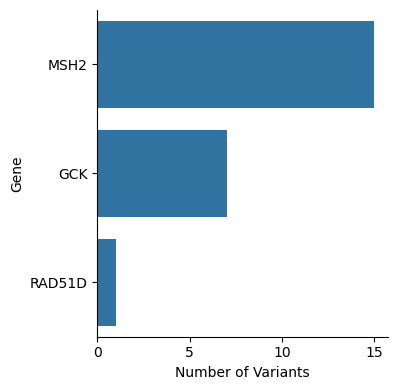

In [31]:
ppi_df = pl.read_csv("../1_inputs/ppi/edgotyping_final_combined_scores.csv").with_columns(
    pl.lit(True).alias("VarChAMP_PPI")
)
ppi_sum_df = pl.read_csv("../1_inputs/ppi/edgotyping_perturb_sum_stats.csv")
ppi_df = ppi_df.join(
    ppi_sum_df,
    on="gene_variant"
)
print("VarChAMP PPI assay unique variants:", ppi_df.unique(subset=["gene_variant"]).shape[0])

pillar_img_dual_ppi_df = pillar_img_dual_df.join( ## .unique(subset=["gene_variant"])
    ppi_df,
    left_on="gene_variant",
    right_on="gene_variant",
    how="full",
    coalesce=True,
    suffix="_ppi"
)

print("VarChAMP PPI Variants overlapped with Pillar:", pillar_img_dual_ppi_df.drop_nulls(subset=["Pillar_Set","VarChAMP_PPI"]).unique(subset="gene_variant").shape[0])
g = sns.catplot(data=pillar_img_dual_ppi_df.drop_nulls(subset=["Pillar_Set","VarChAMP_DUALIPA"]).unique(subset="gene_variant").group_by("Gene").len().sort(by="len", descending=True).rename({"len":"Number of Variants"}).to_pandas(), 
                x="Number of Variants", y="Gene", kind="bar", height=4, aspect=1)

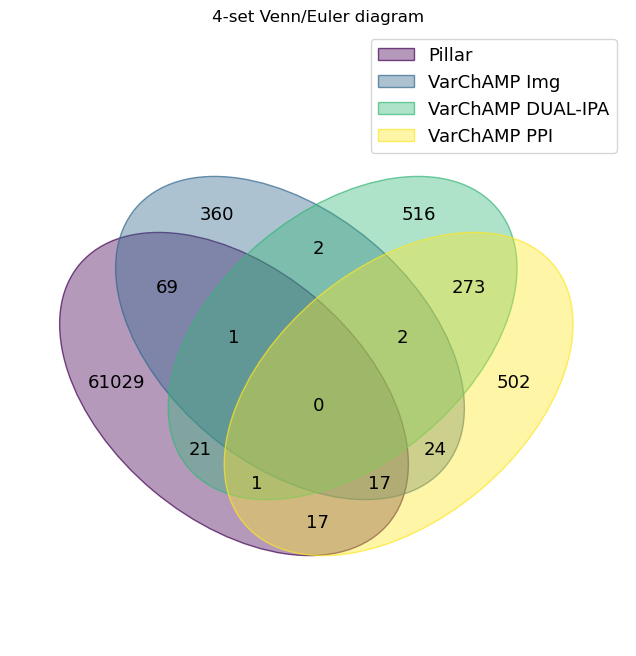

In [32]:
from venn import venn

# Create the diagrams with your data
sets_data = {
    'Pillar': set(pillar_clinvar_single_aa_df["gene_variant"].unique()),
    'VarChAMP Img': set(img_metric_df["gene_variant"].unique()), 
    'VarChAMP DUAL-IPA': set(dual_ipa_df["allele_0"].unique()),
    'VarChAMP PPI': set(ppi_df["gene_variant"].unique())
}

venn(sets_data)
plt.title("4‐set Venn/Euler diagram")
plt.show()

## 2. Functional Assay Mapping

In [19]:
def plot_gene_level_summary(df, hit_col, cell_change, ax=None):
    total_allele_hit_sum_df = (
        df
        .group_by("Gene")
        .agg([
            pl.len().alias("len"),
            pl.col(hit_col).filter(pl.col(hit_col)).len().alias("len_hits"),
        ])
        .with_columns(
            # compute percentage = hit_count / total_variants * 100
            (pl.col("len_hits") / pl.col("len") * 100)
            .round(1)
            .alias("pct_hits")
        )
        # sort by total_variants descending just for nicer plotting order
        .sort("len", descending=False)
    ).to_pandas()
    
    y = range(len(total_allele_hit_sum_df))
    n_genes = len(y)

    # 4. Dynamically scale figure size
    bar_width = 0.4
    if ax is None:
        fig_height = max(6, min(n_genes * 0.3, 40))  # cap size for huge plots
        fig_width = 8
        fig, ax = plt.subplots(figsize=(fig_width, fig_height))

    # Plot bars
    ax.barh(y, total_allele_hit_sum_df["len"], color="skyblue", label="# Variants")
    ax.barh(y, total_allele_hit_sum_df["len_hits"], color="tomato", label="# of Hits")

    # Annotate percentage
    for i, pct in enumerate(total_allele_hit_sum_df["pct_hits"]):
        ax.text(
            total_allele_hit_sum_df.loc[i, "len"] + 0.5,
            i,
            f"{pct:.1f}%",
            ha="left",
            va="center",
            fontsize=10 if n_genes > 20 else 11,
            rotation=0,
        )
    # Axis formatting
    ax.set_yticks(y)
    ax.set_yticklabels(
        total_allele_hit_sum_df["Gene"],
        fontsize=10 if n_genes > 20 else 11,
    )
    ax.set_xlabel("Count", fontsize=11)
    ax.set_title(
        f"{cell_change.upper()} Hits per Gene",
        fontsize=13,
    )
    ax.set_xlim(0, total_allele_hit_sum_df["len"].max() * 1.1)
    ax.legend(fontsize=11, loc="lower right")

### 2.1 Imaging

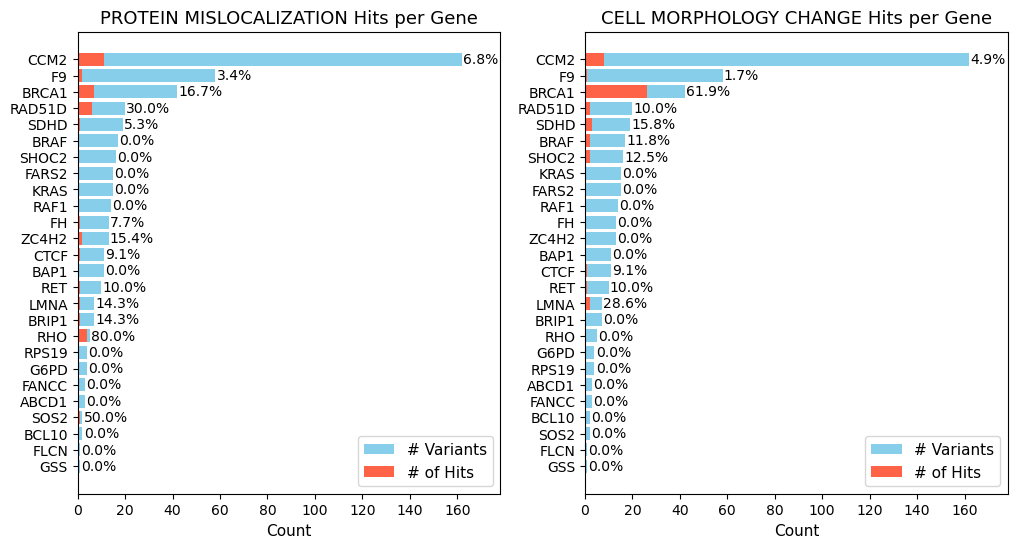

In [20]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
plot_gene_level_summary(img_metric_df, "Altered_GFP_95_both_batches", "Protein Mislocalization", ax=ax[0])
plot_gene_level_summary(img_metric_df, "Altered_Morph_95_both_batches", "Cell Morphology Change", ax=ax[1])

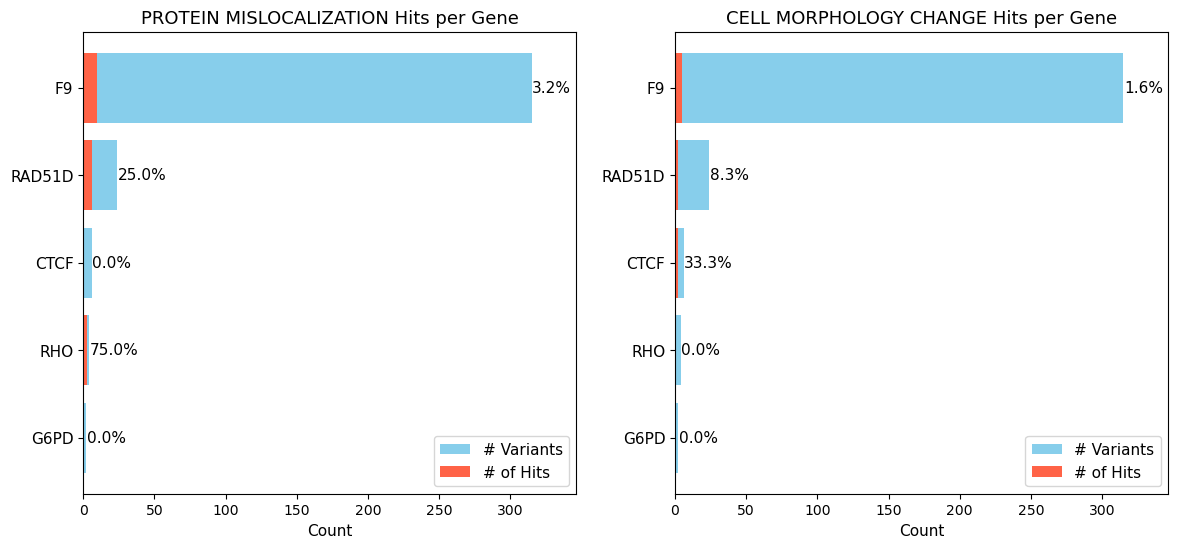

In [21]:
fig, ax = plt.subplots(1,2,figsize=(14,6))
plot_gene_level_summary(pillar_img_df.drop_nulls(subset=["Pillar_Set","VarChAMP_Imaged"]), "Altered_GFP_95_both_batches", "Protein Mislocalization", ax=ax[0])
plot_gene_level_summary(pillar_img_df.drop_nulls(subset=["Pillar_Set","VarChAMP_Imaged"]), "Altered_Morph_95_both_batches", "Cell Morphology Change", ax=ax[1])
plt.subplots_adjust(wspace=0.2)

In [45]:
for i in range(1,7):
    int_name = f"Interval {i} name"
    mavedb_name = f"Interval {i} MaveDB class"
    func_scores = pillar_img_dual_ppi_df.drop_nulls(subset=["Pillar_Set","VarChAMP_Imaged",int_name, mavedb_name])
    # print(func_scores.filter(pl.col(int_name)=="Synonymous"))
    if func_scores.shape[0] > 0:
        display(func_scores.unique(subset="gene_variant")["gene_variant","clinvar_sig",int_name, mavedb_name])
        fig, ax = plt.subplots(1,2,figsize=(15,6))
        sns.boxenplot(
            data=func_scores.unique(subset="gene_variant").to_pandas(),
            x=int_name,
            y=dual_ipa_metric,
            ax=ax[0],
            hue="clinvar_sig",
            dodge=True
        )
        sns.boxenplot(
            data=func_scores.unique(subset="gene_variant").to_pandas(),
            x=mavedb_name,
            y=dual_ipa_metric,
            ax=ax[1],
            hue="clinvar_sig",
            dodge=True
        )

### 2.2 DUAL-IPA assay

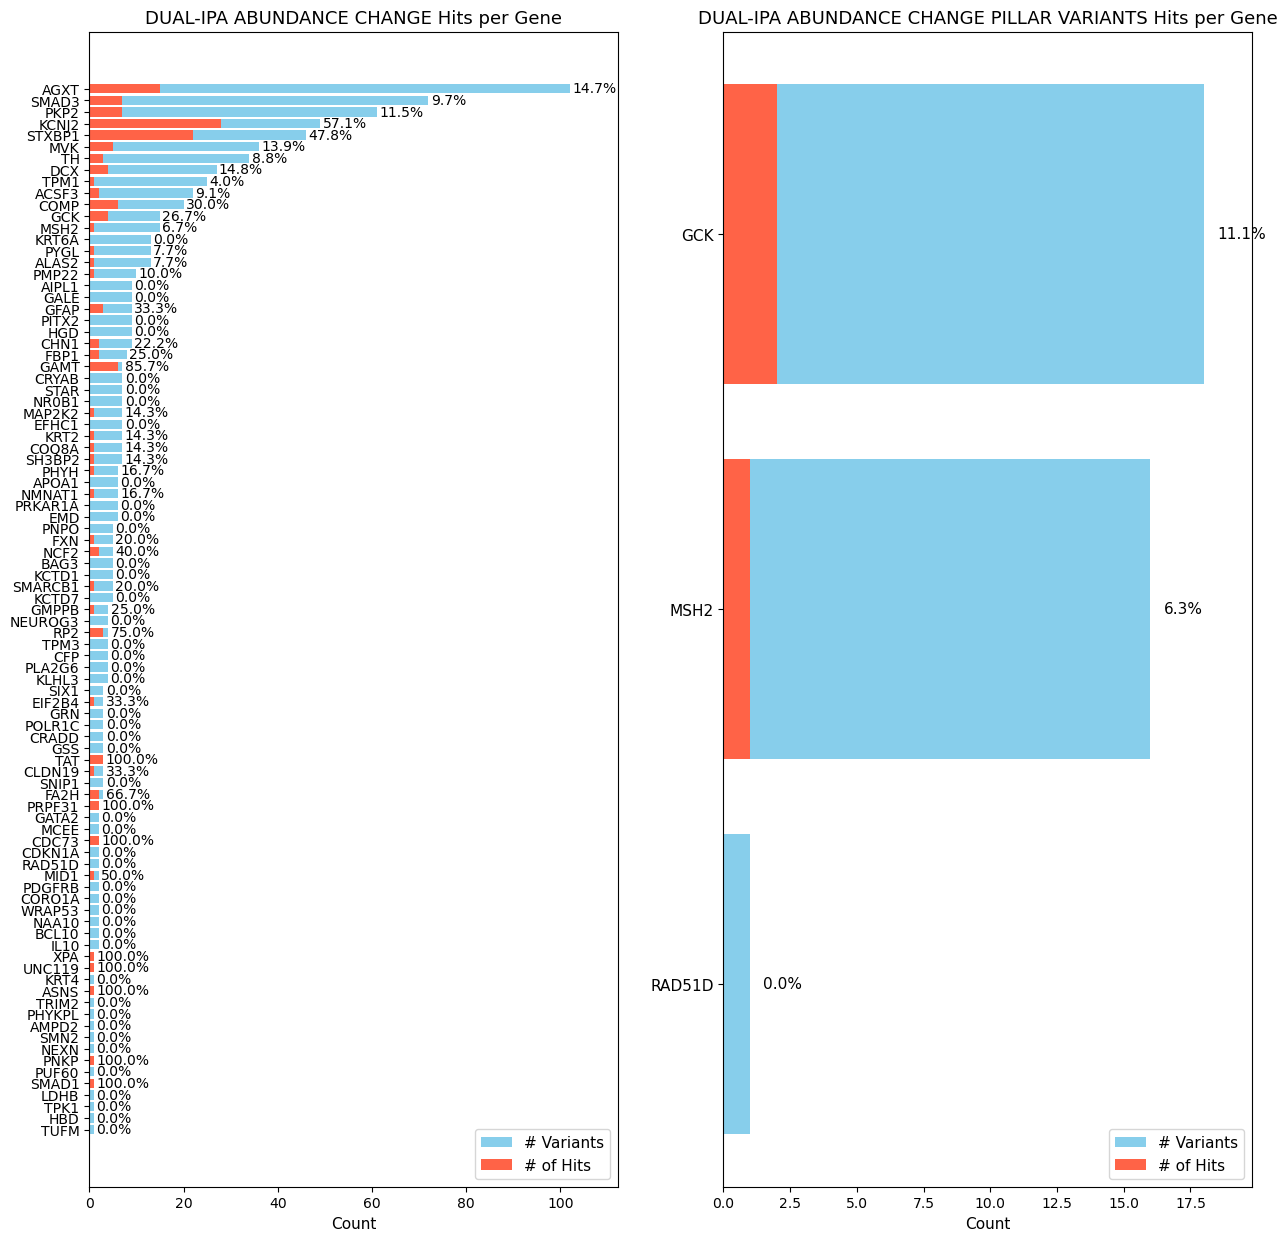

In [47]:
fig, ax = plt.subplots(1,2,figsize=(15,15))
plot_gene_level_summary(dual_ipa_df.with_columns(
    pl.col("gene_variant").str.split("_").list.get(0).alias("Gene")
), "DUALIPA_Abundance_Change", "DUAL-IPA Abundance Change", ax=ax[0])
plot_gene_level_summary(pillar_img_dual_ppi_df.drop_nulls(subset=["Pillar_Set","VarChAMP_DUALIPA"]), "DUALIPA_Abundance_Change", "DUAL-IPA Abundance Change Pillar Variants", ax=ax[1])

gene_variant,clinvar_sig,Interval 1 name,Interval 1 MaveDB class
str,str,str,str
"""MSH2_Lys627Asn""",null,"""Loss of function""","""Abnormal"""
"""MSH2_Leu341Pro""","""Likely pathogenic""","""Loss of function""","""Abnormal"""
"""GCK_Val253Ala""","""Conflicting classifications of…","""Low abundance ""","""Abnormal"""
"""MSH2_Gly40Ser""","""Conflicting classifications of…","""Loss of function""","""Abnormal"""
"""GCK_Ala456Val""","""Pathogenic""","""Decreased activity""","""Abnormal"""
"""MSH2_Arg524Pro""","""Likely pathogenic""","""Loss of function""","""Abnormal"""
"""MSH2_Ala714Val""","""Conflicting classifications of…","""Loss of function""","""Abnormal"""
"""MSH2_Leu440Pro""","""Pathogenic""","""Loss of function""","""Abnormal"""
"""GCK_Arg377His""","""Likely pathogenic""","""Decreased activity""","""Abnormal"""


gene_variant,clinvar_sig,Interval 2 name,Interval 2 MaveDB class
str,str,str,str
"""MSH2_Leu92Val""","""Conflicting classifications of…","""WT-like""","""Normal"""
"""MSH2_Leu341Pro""","""Likely pathogenic""","""WT-like""","""Normal"""
"""MSH2_Leu440Pro""","""Pathogenic""","""WT-like""","""Normal"""
"""MSH2_Pro622Leu""","""Pathogenic""","""WT-like""","""Normal"""
"""MSH2_Thr335Ile""","""Uncertain significance""","""WT-like""","""Normal"""
"""MSH2_Glu562Val""","""Conflicting classifications of…","""WT-like""","""Normal"""
"""MSH2_Ala305Thr""","""Conflicting classifications of…","""WT-like""","""Normal"""
"""GCK_Ala456Val""","""Pathogenic""","""Hyperactive""","""Not specified"""
"""MSH2_Arg524Pro""","""Likely pathogenic""","""WT-like""","""Normal"""


gene_variant,clinvar_sig,Interval 3 name,Interval 3 MaveDB class
str,str,str,str
"""GCK_Ala456Val""","""Pathogenic""","""Synonymous""","""Abnormal"""
"""GCK_Met251Thr""","""Likely pathogenic""","""Synonymous""","""Abnormal"""
"""GCK_Ala378Val""","""Pathogenic""","""Synonymous""","""Abnormal"""
"""GCK_Val253Ala""","""Conflicting classifications of…","""Synonymous""","""Abnormal"""
"""GCK_Met381Arg""","""Likely pathogenic""","""Synonymous""","""Abnormal"""
"""GCK_Arg377His""","""Likely pathogenic""","""Synonymous""","""Abnormal"""
"""GCK_Ala387Glu""","""Likely pathogenic""","""Synonymous""","""Abnormal"""


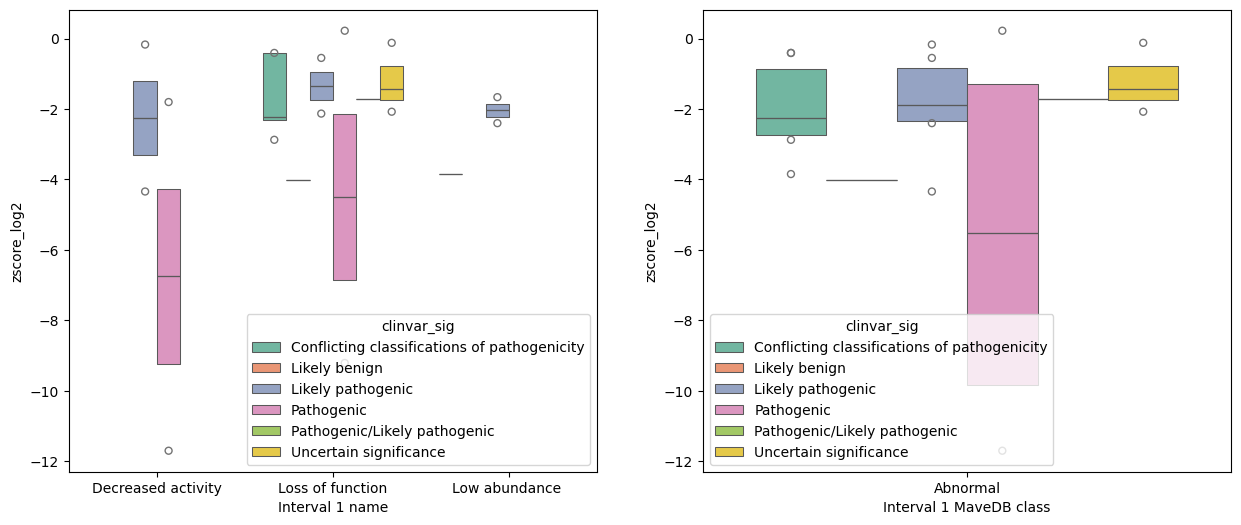

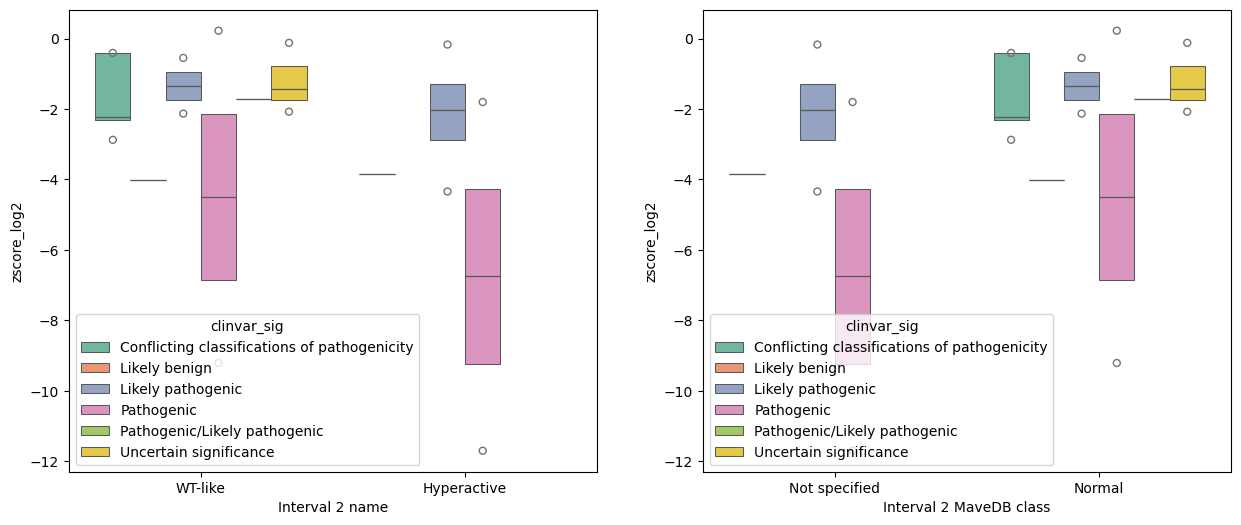

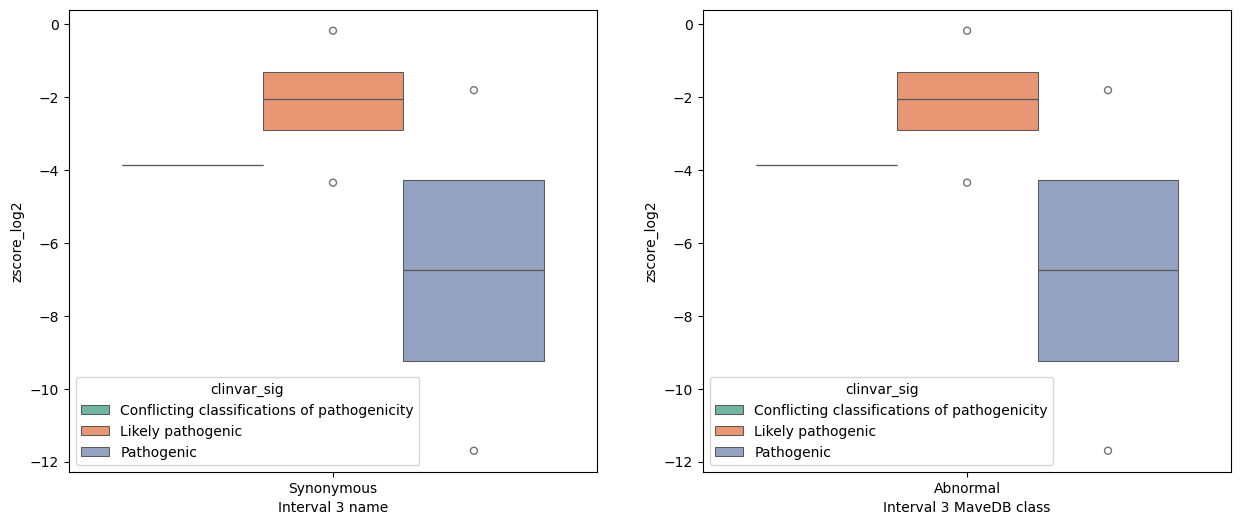

In [51]:
pl.Config.set_tbl_rows(25)  # Show all rows
# pl.Config.set_tbl_cols(40)  # Show all columns
for i in range(1,7):
    int_name = f"Interval {i} name"
    mavedb_name = f"Interval {i} MaveDB class"
    func_scores = pillar_img_dual_ppi_df.drop_nulls(subset=["Pillar_Set","VarChAMP_DUALIPA",int_name, mavedb_name])
    # print(func_scores.filter(pl.col(int_name)=="Synonymous"))
    if func_scores.shape[0] > 0:
        display(func_scores.unique(subset="gene_variant")["gene_variant","clinvar_sig",int_name, mavedb_name])
        fig, ax = plt.subplots(1,2,figsize=(15,6))
        hue_order = sorted(func_scores.drop_nulls("clinvar_sig").unique("clinvar_sig")["clinvar_sig"])
        sns.boxenplot(
            data=func_scores.unique(subset="gene_variant").to_pandas(),
            x=int_name,
            y=dual_ipa_metric,
            ax=ax[0],
            hue="clinvar_sig",
            dodge=True,
            palette="Set2",
            hue_order=hue_order
        )
        sns.boxenplot(
            data=func_scores.unique(subset="gene_variant").to_pandas(),
            x=mavedb_name,
            y=dual_ipa_metric,
            ax=ax[1],
            hue="clinvar_sig",
            dodge=True,
            palette="Set2",
            hue_order=hue_order
        )

### 2.3 PPI assays

In [56]:
for i in range(1,7):
    int_name = f"Interval {i} name"
    mavedb_name = f"Interval {i} MaveDB class"
    func_scores = pillar_img_dual_ppi_df.drop_nulls(subset=["Pillar_Set","VarChAMP_PPI",int_name, mavedb_name])
    # print(func_scores)
    # print(func_scores.filter(pl.col(int_name)=="Synonymous"))
    if func_scores.shape[0] > 0:
        display(func_scores["gene_variant","clinvar_sig",int_name, mavedb_name])
    # if func_scores.shape[0] > 0:
    #     fig, ax = plt.subplots(1,2,figsize=(12,6))
    #     sns.boxenplot(
    #         data=func_scores.unique(subset="gene_variant").to_pandas(),
    #         x=int_name,
    #         y="perturbed_percentage",
    #         ax=ax[0]
    #     )
    #     sns.boxenplot(
    #         data=func_scores.unique(subset="gene_variant").to_pandas(),
    #         x=mavedb_name,
    #         y="perturbed_percentage",
    #         ax=ax[1]
    #     )

gene_variant,clinvar_sig,Interval 1 name,Interval 1 MaveDB class
str,str,str,str
"""GCK_Ala387Glu""","""Likely pathogenic""","""Low abundance ""","""Abnormal"""
"""GCK_Ala387Glu""","""Likely pathogenic""","""Low abundance ""","""Abnormal"""
"""GCK_Ala387Glu""","""Likely pathogenic""","""Decreased activity""","""Abnormal"""
"""GCK_Ala387Glu""","""Likely pathogenic""","""Decreased activity""","""Abnormal"""


gene_variant,clinvar_sig,Interval 2 name,Interval 2 MaveDB class
str,str,str,str
"""GCK_Ala387Glu""","""Likely pathogenic""","""Hyperactive""","""Not specified"""
"""GCK_Ala387Glu""","""Likely pathogenic""","""Hyperactive""","""Not specified"""


gene_variant,clinvar_sig,Interval 3 name,Interval 3 MaveDB class
str,str,str,str
"""GCK_Ala387Glu""","""Likely pathogenic""","""Synonymous""","""Abnormal"""
"""GCK_Ala387Glu""","""Likely pathogenic""","""Synonymous""","""Abnormal"""


In [57]:
ppi_df.filter(pl.col("gene_variant")=="GCK_Ala387Glu")

ad_orf_id,nt_change,final_score_wt,symbol,db_orf_id,edgotype,aa_change,final_score,ad_symbol,edgotype_wt_2,gene_variant,edgotype_wt_final,VarChAMP_PPI,total_occurrences,not_perturbed_count,inconclusive_count,perturbed_count,not_perturbed_percentage,inconclusive_percentage,perturbed_percentage
i64,str,i64,str,i64,str,str,i64,str,str,str,str,bool,i64,i64,i64,i64,f64,f64,f64
54784,"""1160C>A""",3,"""GCK""",3689,"""not perturbed""","""Ala387Glu""",3,"""GCKR""","""not perturbed""","""GCK_Ala387Glu""","""not perturbed""",true,2,1,0,1,50.0,0.0,50.0
70835,"""1160C>A""",4,"""GCK""",3689,"""perturbed""","""Ala387Glu""",0,"""SPDYE4""","""perturbed""","""GCK_Ala387Glu""","""perturbed""",true,2,1,0,1,50.0,0.0,50.0
